In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

In [2]:
from sps4lat import model as mod
from sps4lat import preprocessing as pre
from sps4lat import optimize as opti
from sps4lat import utils as uti
from fgspectra import cross as fgc
from fgspectra import frequency as fgf
from fgspectra import power as fgp
import healpy as hp 
import numpy as np 
import matplotlib.pyplot as plt
import warnings
import scipy.optimize as opt
#warnings.filterwarnings("ignore")


In [3]:
def _get_order_synfast(cl):
    shape = cl.shape
    N_freqs = shape[0]
    lst_idx = []
    for k in range(N_freqs):
        T = np.where(np.eye(N_freqs,k=k) == 1)
        lst = [[T[0][i], T[1][i]] for i in range(len(T[0]))]
        lst_idx.extend(lst)
    res = [cl[i,j,:] for i,j in lst_idx]
    return res

In [4]:
#### SKY SIMULATION ####
nside = 512
lmax = 3 * nside - 1
ells = np.linspace(0, lmax, lmax + 1)
freqs = np.array([30., 44., 70., 100., 143., 217., 353.])
N = len(freqs)

## Noise ##
nwhite = np.array([145.,149.,137.,65.,43.,66.,200.])*np.pi/180./60./10.
noise = mod.WhiteNoise(ell=np.linspace(0,lmax,lmax+1), nu=freqs, nwhite=nwhite)

## Foregrounds ##
# fgs_sed = fgf.ThermalSZ(nu=freqs, nu_0=150.)
# fgs_power = fgp.tSZ_150_bat()
# fgs_power.set_defaults(ell=np.linspace(0,lmax,lmax+1).astype('int'), ell_0=3000, amp=4.66)
# fgs_dict = {'sed_kwargs': {'kwseq': [{'nu': freqs, 'nu_0': 150.}, 
#                                      {'nu': freqs, 'nu_0': 150., 'temp': 9.7, 'beta': 2.08}]}, 
#             'cl_kwargs': {'kwseq': [{'ell': ells, 'ell_0': 3000, 'amp': 4.66}, 
#                                     {'ell': ells, 'alpha': 2.-1.20, 'ell_0': 3000, 'amp': 6.1}, 
#                                     {'ell': ells, 'ell_0': 3000, 'amp': -0.09*np.sqrt(6.1*4.66)}]}}
# fgs = fgc.SZxCIB()
# fgs.set_defaults(**fgs_dict)
# fgs = fgc.FactorizedCrossSpectrum(sed=fgs_sed, cl=fgs_power)
# fgs_dl = fgs.eval()
# to_dl = ells * (ells + 1) / 2. / np.pi
# to_dl[0] = 1.
# fgs_cl = fgs_dl / to_dl

fgs_sed = fgf.PowerLaw(nu=freqs, nu_0=500., beta = 3.)
fgs_cl = fgp.FreeCls(ell=ells, cls = 100*np.ones(len(ells)))
fgs = fgc.FactorizedCrossSpectrum(sed=fgs_sed, cl=fgs_cl)

## CMB ##
cmb_cls = mod.CMB(ell=ells)
cmb_sed = mod.FreeSED(nu=freqs, sed=np.ones(N))
cmb = mod.FactorizedCrossSpectrum(sed=cmb_sed, cl=cmb_cls)

## Total ##
model_init = fgc.Sum(cmb,fgs,noise)

cl = model_init.eval()# + fgs_cl

print(cl.shape)
## Generating maps ##
mp = hp.synfast(_get_order_synfast(cl),nside=nside, new=True, verbose=False, pol=False)
for i,fr in enumerate(freqs): 
    filename = '../data/test/maps/test_pl/{:d}GHz.fits'.format(int(fr))
    hp.write_map(filename, mp[i],overwrite = True)

(7, 7, 1536)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


In [5]:
#### PLOTS OF MAPS ####
map_list = []
for i,fr in enumerate(freqs): 
    filename = '../data/test/maps/test_pl/{:d}GHz.fits'.format(int(fr))
    map_list.append(hp.read_map(filename, verbose = False))
alms = uti.get_alms(map_list)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [6]:
nbins = 100

#### BINNING EMP COV + PLOT ####
bins = np.linspace(5,lmax,nbins).astype('int')
emp_cov = pre.empirical_covmat(alms)[...,2:]
ell = np.linspace(2,lmax,lmax-1)
ell_mean, emp_cov_binned = uti.bin_spectra(ell=ell, spectra=emp_cov, bins=bins) 

bins_max = bins[1:]
bins_min = bins[:-1]
n_bins = len(bins) - 1
#weights = np.array([(bins_max[i] - bins_min[i]) * (bins_max[i] + bins_min[i]) for i in range(n_bins)])
weights = bins_max * (2 * bins_max + 1) - (2 * bins_min + 1) * (2 * bins_min - 1) / 2

In [7]:
fig = plt.figure(figsize=(18, 14))

<Figure size 1296x1008 with 0 Axes>

In [12]:
#### MODEL OF THE COVMAT ####

## Noise ##
noise = mod.WhiteNoise(ell=ell_mean, nu=freqs, nwhite=None)

## CMB ##
cmb_cls = mod.CMB(ell=ell_mean, amp=None)
cmb_sed = mod.FreeSED(nu=freqs, sed=np.ones(N))
cmb = mod.FactorizedCrossSpectrum(sed=cmb_sed, cl=cmb_cls)
    
## FGS ##
fgs_sed = fgf.PowerLaw(nu=freqs, nu_0=500., beta = None)
fgs_cls = fgp.FreeCls(ell=ell_mean, cls = 100.*np.ones(len(ell_mean)))
fgs = mod.FactorizedCrossSpectrum(sed=fgs_sed, cl=fgs_cls)

## Total ##
cl_mod = mod.Sum(cmb, fgs, noise)


#### STARTING POINT TOF THE OPTMIZATION ####

def start(emp_cov, dimension, bins):
    n_bins = len(bins) - 1
    bins_max = bins[1:]
    bins_min = bins[:-1]
    emp_tot = np.einsum('b,ijb->ij', weights / n_bins, emp_cov)
    _, eigvects = np.linalg.eigh(emp_tot)
    noise = np.diag(emp_tot)
    A = eigvects[::-1,::-1]
    p_l = np.einsum('ba,bcl,cd->adl',A,emp_cov,A)
    return noise, A[:,:dimension], p_l[:dimension,:dimension,:]

noise, A, pl = start(emp_cov_binned,3,bins)

## Start dictionary ##
# dict_start = {'kwseq': [{'cl_kwargs': {'cls': pl[0,0,:]}}, 
#                         {'cl_kwargs': {'cls': pl[1,1,:]}}, 
#                         {'nwhite': noise}]}

# dict_start = {'kwseq': [{'cl_kwargs': {'cls': pl[2,2,:]}}, 
                        
#                         #{'cl_kwargs': {'kwseq': [{'cls': pl[1,1,:]},
#                         #                         {'cls': pl[0,0,:]},
#                         #                         {'cls': pl[0,1,:]}]}},
#                         {'nwhite': noise}]}

dict_start={'kwseq': [{'cl_kwargs':{'amp':np.random.uniform(0,2)}},
                      {'sed_kwargs':{'beta':np.random.uniform(1.5,4.5)}},
                      {'nwhite': noise}]}

mat_start = cl_mod.eval(**dict_start)

#### OPTIMIZATION ####

cl_mod.prepare_for_arrays(dict_start)
theta_start = cl_mod.kwargs2array(dict_start)

min_bounds_dict ={'kwseq': [{'cl_kwargs':{'amp':-1e-25}},
                            {'sed_kwargs':{'beta':0.}},
                            {'nwhite': -1e-25*np.ones(len(freqs))}]}

min_bounds_array = cl_mod.kwargs2array(min_bounds_dict)
bounds = opt.Bounds(lb=min_bounds_array,ub=np.inf * np.ones(len(theta_start)),keep_feasible=True)

param_optimised_deriv, res = opti.optimiser_test(emp_cov=emp_cov_binned, model=cl_mod, 
                                                 param_start=dict_start, bins=bins, fig=fig, deriv=True, delta=100,
                                                 kwargs_opt = {'bounds':bounds,'method':'TNC', 
                                                              'options':{'ftol': 1e-15, 'gtol': 1e-15, 'xtol':1e-15,
                                                                         'eps': 1e-15, 'maxfun': 10000000, 'maxiter': 1000000,
                                                                        'eta':0.1, 'disp': True}})


{'kwseq': [{'cl_kwargs': {'amp': array(1.46189988)}}, {'sed_kwargs': {'beta': array(2.96497044)}}, {'nwhite': array([0.00332335, 0.0034903 , 0.00294591, 0.00113267, 0.        ,
       0.        , 0.        ])}]}
DONE
{'kwseq': [{'cl_kwargs': {'amp': array(1.00307907)}}, {'sed_kwargs': {'beta': array(3.00049737)}}, {'nwhite': array([0.00453779, 0.00112117, 0.00426629, 0.00146109, 0.        ,
       0.        , 0.        ])}]}
{'kwseq': [{'cl_kwargs': {'amp': array(1.00307902)}}, {'sed_kwargs': {'beta': array(3.00049737)}}, {'nwhite': array([0.00458815, 0.        , 0.00428436, 0.00399801, 0.        ,
       0.00749604, 0.        ])}]}
{'kwseq': [{'cl_kwargs': {'amp': array(1.003079)}}, {'sed_kwargs': {'beta': array(3.00049737)}}, {'nwhite': array([0.00455277, 0.00057957, 0.00425444, 0.00155511, 0.        ,
       0.        , 0.        ])}]}
DONE
{'kwseq': [{'cl_kwargs': {'amp': array(0.97772782)}}, {'sed_kwargs': {'beta': array(3.00049777)}}, {'nwhite': array([0.00357349, 0.00489142, 0.0

In [13]:
print("End kl :", res.fun) 
print("Success :", res.success) 
print("Message :", res.message) 
print("Number iterations :", res.nit) 
print("number call fun :", res.nfev)

End kl : 506659.85726995923
Success : True
Message : Converged (|x_n-x_(n-1)| ~= 0)
Number iterations : 68
number call fun : 648


{'kwseq': [{'cl_kwargs': {'amp': array(0.97772782)}}, {'sed_kwargs': {'beta': array(3.00049777)}}, {'nwhite': array([0.00435398, 0.0044632 , 0.00413602, 0.0022455 , 0.        ,
       0.00225082, 0.        ])}]}


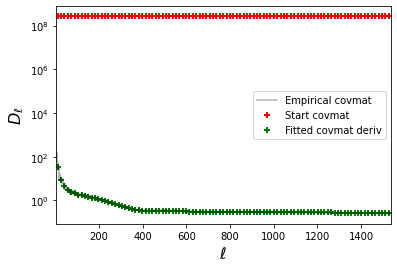

In [14]:
#### PLOT OF BEST-FIT ####
print(param_optimised_deriv)
cov_opti_deriv = cl_mod.eval(**param_optimised_deriv)
i=-1 #freq to plot
plt.figure()
plt.plot(ell,emp_cov[i,i,:],alpha = .3, c = 'k', label = 'Empirical covmat')
plt.scatter(ell_mean,mat_start[i,i,:],lw=2, c = 'r', label = 'Start covmat', marker = '+')
plt.scatter(ell_mean,np.abs(cov_opti_deriv[i,i,:]),lw=2, c = 'g', label = 'Fitted covmat deriv', marker = '+')
plt.yscale('log')

plt.xlabel('$\ell$', fontsize=16)
plt.xlim(2,lmax)
plt.ylabel('$D_\ell$', fontsize =16)
# plt.yscale('log')
plt.legend()
plt.show()

In [11]:
#### WIENER FILETERING ####

lst = cl_mod.eval_terms(**param_optimised_deriv)
cpt = 0
fr = 4
inv_R = (np.linalg.inv(cov_opti_deriv.T)).T
w = np.einsum('abl,bcl->acl',lst[cpt],inv_R)
w_full = np.zeros((N,N,lmax+1))
bins_max = bins[1:]
bins_min = bins[:-1]
for i in range(len(bins)-1):
    w_full[...,bins_min[i]:bins_max[i]] = np.tile(w[...,i,np.newaxis],bins_max[i]-bins_min[i])
alm_filter  = alms.copy()
print(alms.shape)
for l in range(0,lmax-1) : 
    ind_list = []
    for m in range(0,l+1):
        ind_list.append(hp.Alm.getidx(lmax,l,m)) 
    alm_filter[:,ind_list] = np.dot(w_full[:,:,l],alms[:,ind_list])
    

(7, 1180416)


In [12]:
#### WIENER FILETERED MAPS ####

maps_resulting = []
for alm in alm_filter:
    maps_resulting.append(hp.alm2map(alm, nside=nside, verbose = False))
    
hp.mollview(maps_resulting[fr], min=-300,max=300, title = '{:d}GHz Filtered for CMB'.format(int(freqs[fr])))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
# fgs_sed = fgf.ThermalSZ(nu=freqs, nu_0=150.)
# fgs_power = fgp.tSZ_150_bat()
# fgs_power.set_defaults(ell=np.linspace(0,lmax,lmax+1).astype('int'), ell_0=3000, amp = 4.66)
# fgs = fgc.FactorizedCrossSpectrum(sed=fgs_sed,cl=fgs_power)
fgs_dict = {'sed_kwargs': {'kwseq': [{'nu': freqs, 'nu_0': 150.}, 
                                     {'nu': freqs, 'nu_0': 150., 'temp': 9.7, 'beta': 2.08}]}, 
            'cl_kwargs': {'kwseq': [{'ell': np.linspace(0,lmax,lmax+1), 'ell_0': 3000, 'amp': 4.66}, 
                                    {'ell': np.linspace(0,lmax,lmax+1), 'alpha': 2.-1.20, 'ell_0': 3000, 'amp': 6.1}, 
                                    {'ell': np.linspace(0,lmax,lmax+1), 'ell_0': 3000, 'amp': -0.09*np.sqrt(6.1*4.66)}]}}
fgs = fgc.SZxCIB()
fgs.set_defaults(**fgs_dict)
cl_init = fgs.eval()

plt.figure()
ell_test = np.linspace(0,lmax,lmax+1)
# plt.plot(ell,ell**2*emp_cov[1,1,:],alpha = .6, c = 'k', label = 'Empirical covmat')
# plt.scatter(ell_mean,ell_mean**2*cov_opti_deriv[1,1,:],lw=2, c = 'r', label = 'Fitted covmat')
plt.plot(ell_test,cl_init[fr,fr,:],alpha = .6,lw=2, c = 'red', label = 'Init spectra')
plt.scatter(ell_mean,ell_mean*(ell_mean+1)/2/np.pi*lst[1][fr,fr,:],alpha = 1.,lw=2, c = 'orange', label = 'Fitted spectra', marker='+')
plt.xlabel('$\ell$', fontsize=16)
plt.xlim(2,lmax-10)
# plt.ylim(0,5)
plt.ylabel('$D_\ell$', fontsize =16)
plt.title('{:d}x{:d}GHz'.format(int(freqs[fr]),int(freqs[fr])), fontsize = 20)
# plt.yscale('log')
plt.legend()
# plt.savefig('/Users/benjamin_brng/Desktop/cl_{:d}GHz_fgs.png'.format(int(freqs[fr])))
#
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
cmb_cls = mod.CMB(ell=np.linspace(0,lmax,lmax+1))
cmb_sed = mod.FreeSED(nu=freqs, sed=np.ones(N))
cmb = mod.FactorizedCrossSpectrum(sed=cmb_sed, cl=cmb_cls)
cl_init = cmb.eval()
cl_plot = hp.anafast(hp.synfast(cl_init[fr,fr,:], nside = 512))

plt.figure()
ell_test = np.linspace(0,lmax,lmax+1)
# plt.plot(ell,ell**2*emp_cov[1,1,:],alpha = .6, c = 'k', label = 'Empirical covmat')
# plt.scatter(ell_mean,ell_mean**2*cov_opti_deriv[1,1,:],lw=2, c = 'r', label = 'Fitted covmat')
plt.plot(ell_test,ell_test**2*cl_plot,alpha =1,lw=2, c = 'red', label = 'Init spectra')
plt.plot(ell_mean,ell_mean**2*lst[0][fr,fr,:],alpha = 1.,lw=2, c = 'orange', label = 'Fitted spectra', marker = '+', 
         ls = None)

plt.xlabel('$\ell$', fontsize=16)
plt.xlim(2,lmax-10)
# plt.ylim(1e-5,40000)
plt.ylabel('$D_\ell$', fontsize =16)
plt.title('{:d}x{:d}GHz'.format(int(freqs[fr]),int(freqs[fr])), fontsize = 20)
# plt.yscale('log')
plt.legend()
# plt.savefig('/Users/benjamin_brng/Desktop/cl_{:d}GHz_cmb.png'.format(int(freqs[fr])))
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/healpy/sphtfunc.py:395: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
nwhite = np.array([145.,149.,137.,65.,43.,66.,200.])*np.pi/180./60./10.
noise = mod.WhiteNoise(ell=np.linspace(0,lmax,lmax+1), nu=freqs, nwhite=nwhite)
cl_init = noise.eval()

print(nwhite)
print(param_optimised_deriv['kwseq'][-1]['nwhite'])

plt.figure()
ell_test = np.linspace(0,lmax,lmax+1)
# plt.plot(ell,ell**2*emp_cov[1,1,:],alpha = .6, c = 'k', label = 'Empirical covmat')
# plt.scatter(ell_mean,ell_mean**2*cov_opti_deriv[1,1,:],lw=2, c = 'r', label = 'Fitted covmat')
plt.plot(ell_test,ell_test**2*cl_init[fr,fr,:],alpha = .6,lw=2, c = 'red', label = 'Init spectra')
plt.scatter(ell_mean,ell_mean**2*lst[2][fr,fr,:],alpha = 1.,lw=2, c = 'orange', label = 'Fitted spectra', marker='+')
plt.xlabel('$\ell$', fontsize=16)
plt.xlim(2,lmax-10)
# plt.ylim(1e-5,40000)
plt.ylabel('$D_\ell$', fontsize =16)
plt.title('{:d}x{:d}GHz'.format(int(freqs[fr]),int(freqs[fr])), fontsize = 20)
# plt.yscale('log')
plt.legend()
# plt.savefig('/Users/benjamin_brng/Desktop/cl_{:d}GHz_noise.png'.format(int(freqs[fr])))
plt.show()

[0.00421788 0.00433423 0.00398517 0.00189077 0.00125082 0.00191986
 0.00581776]
[0.00417303 0.00428718 0.00394205 0.00187217 0.0012357  0.00191369
 0.00325851]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …